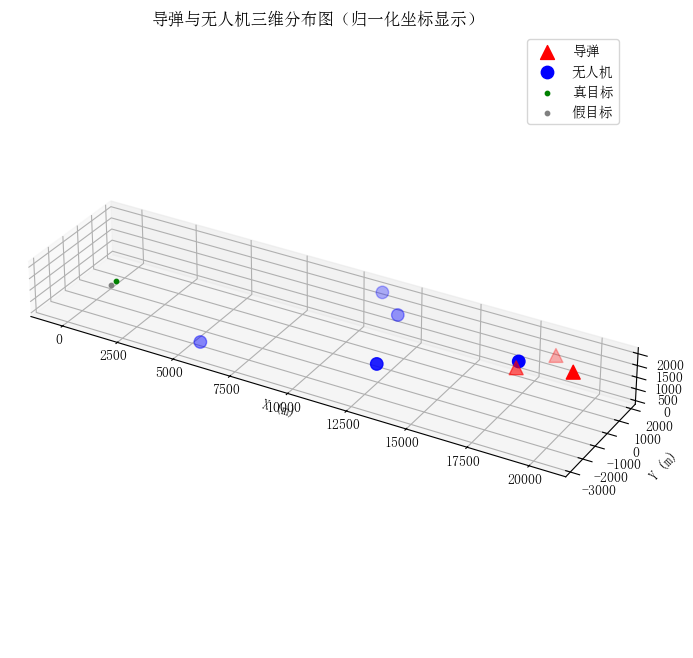

In [19]:
# 导入所需库
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = ["SimSun"]
plt.rcParams['axes.unicode_minus'] = False
# 定义导弹和无人机的坐标
missiles = [
    (20000, 0, 2000),
    (19000, 600, 2100),
    (18000, -600, 1900)
]
FYs = [
    (17800, 0, 1800),
    (12000, 1400, 1400),
    (6000, -3000, 700),
    (11000, 2000, 1800),
    (13000, -2000, 1300)
]

# 创建3D图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制导弹点
mx, my, mz = zip(*missiles)
ax.scatter(mx, my, mz, c='r', marker='^', s=100, label='导弹')

# 绘制无人机点
ux, uy, uz = zip(*FYs)
ax.scatter(ux, uy, uz, c='b', marker='o', s=80, label='无人机')

# 绘制真目标底面圆心
# 实际为200，这里为了区分真假目标调高点
ax.scatter([0], [400], [0], c='g', marker='o', s=10, label='真目标')
ax.scatter([0], [0], [0], c='gray', marker='o', s=10,  label='假目标')

# 设置坐标轴标签
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')

# 适当缩放坐标轴（归一化显示）
all_x = mx + ux + (0,)
all_y = my + uy + (200,)
all_z = mz + uz + (0,)
ax.set_box_aspect([max(all_x)-min(all_x), max(all_y)-min(all_y), max(all_z)-min(all_z)])

# 添加图例
ax.legend()

# 设置标题
ax.set_title('导弹与无人机三维分布图（归一化坐标显示）')

plt.show()

# Problem 1
计算给定条件下的遮蔽时长

In [20]:
M1 = np.array([20000, 0, 2000])
f1 = np.array([17800, 0, 1800])
v_f1 = 120
v_M1 = 300
v_smoke = 3
gravity = 9.80655
fake_target = np.array([0,0,0])
true_target = np.array([0, 200, 5])  #此为质心，高为10，半径为7
true_target_R = 7
true_target_H = 10
smoke_R = 10

M1_dir = (fake_target - M1) / np.linalg.norm(fake_target - M1)
#无人机只能水平飞行
f1_dir = np.array([-1, 0, 0])
#计算5.1s后的位置
t_initial = 5.1
M1_pos_at_5_1 = M1 + M1_dir * v_M1 * t_initial
bomb_pos_at_5_1 = f1 + f1_dir * v_f1 * t_initial - np.array([0, 0, gravity]) * 3.6 * 3.6 / 2
print("5.1s后，炸弹位置：", bomb_pos_at_5_1)
print("5.1s时，导弹位置：", M1_pos_at_5_1)


# 从5.1s开始计时
t_index = np.linspace(0, 20, 20001)
M1_positions = M1_pos_at_5_1 + np.outer(t_index, M1_dir * v_M1)
smoke_positions = bomb_pos_at_5_1 - np.outer(t_index, np.array([0, 0, v_smoke]))

# 使用向量化操作计算所有时间点的相交情况
def vectorized_intersection(missile_positions, target_pos, smoke_centers, radius):
    line_dir = target_pos - missile_positions
    line_len_sq = np.sum(line_dir **2, axis=1)
    vec_missile_to_smoke = smoke_centers - missile_positions
    t = np.sum(vec_missile_to_smoke * line_dir, axis=1) / line_len_sq
    t = np.clip(t, 0, 1)
    closest_points = missile_positions + np.expand_dims(t, axis=1) * line_dir
    distances = np.linalg.norm(closest_points - smoke_centers, axis=1)
    return distances <= radius

# 计算所有时间点的相交情况
intersection_results = vectorized_intersection(
    M1_positions, 
    true_target, 
    smoke_positions, 
    smoke_R
)

# 找出所有相交的时间步
intersection_indices = np.where(intersection_results)[0]
intersection_times = t_index[intersection_indices]

# 计算总相交时间
if len(intersection_indices) > 0:
    # 计算索引之间的差值（判断是否连续）
    diffs = np.diff(intersection_indices)  # 相邻索引的差值
    split_points = np.where(diffs != 1)[0] + 1
    continuous_segments = np.split(intersection_indices, split_points)
    segment_durations = np.array([
        t_index[seg[-1]] - t_index[seg[0]] 
        for seg in continuous_segments
    ])
    total_intersection_time = np.sum(segment_durations)
    time_segments = [
        (t_index[seg[0]], t_index[seg[-1]]) 
        for seg in continuous_segments
    ]
    print(f"相交的时间点数量: {len(intersection_indices)}")
    print(f"总相交时间: {total_intersection_time:.6f} 秒")
    print(f"相交时间段: {time_segments}")
else:
    print("导弹与烟雾球体没有相交")
    total_intersection_time = 0


5.1s后，炸弹位置： [17188.           0.        1736.453556]
5.1s时，导弹位置： [18477.59309898     0.          1847.7593099 ]
相交的时间点数量: 1444
总相交时间: 1.443000 秒
相交时间段: [(2.9050000000000002, 4.348)]


In [21]:
true_target_corner_1 = true_target - np.array([0, true_target_R, true_target_H / 2])
true_target_corner_2 = true_target - np.array([0, true_target_R, -true_target_H / 2])
true_target_corner_3 = true_target - np.array([0, -true_target_R, true_target_H / 2])
true_target_corner_4 = true_target - np.array([0, -true_target_R, -true_target_H / 2])

t_index = np.linspace(0, 20, 20001)
M1_positions = M1_pos_at_5_1 + np.outer(t_index, M1_dir * v_M1)
smoke_positions = bomb_pos_at_5_1 - np.outer(t_index, np.array([0, 0, v_smoke]))

def check_four_lines_no_intersection(missile_positions, corner1, corner2, corner3, corner4, smoke_centers, radius):
    """
    检查四条直线（导弹位置到四个目标角落点）是否都与球体无交点
    
    参数:
        missile_positions: 导弹位置数组，形状为(n, 3)，n为时间步数
        corner1-4: 四个目标角落点的坐标，每个为形状(3,)的数组
        smoke_centers: 烟雾球体中心位置数组，形状为(n, 3)
        radius: 烟雾球体半径
        
    返回:
        布尔数组，形状为(n,)，每个元素为True表示对应时间步四条直线都与球体无交点
    """
    def line_sphere_no_intersection(missile_pos, target_corner, smoke_center, radius):
        """检查单条直线（导弹位置到目标角落点）是否与球体无交点"""
        # 计算直线方向向量
        line_dir = target_corner - missile_pos
        line_len_sq = np.sum(line_dir **2, axis=1, keepdims=True)
        
        # 处理直线长度为0的特殊情况（避免除零）
        line_len_sq = np.maximum(line_len_sq, 1e-10)
        
        # 计算导弹到烟雾中心的向量
        vec_missile_to_smoke = smoke_center - missile_pos
        
        # 计算参数t（直线上最近点的参数）
        t = np.sum(vec_missile_to_smoke * line_dir, axis=1, keepdims=True) / line_len_sq
        t = np.clip(t, 0, 1)  # 限制在直线段范围内
        
        # 计算直线上的最近点
        closest_points = missile_pos + t * line_dir
        
        # 计算最近点到烟雾中心的距离
        distances = np.linalg.norm(closest_points - smoke_center, axis=1)
        
        # 返回是否无交点（距离 > 半径）
        return distances < radius
    
    # 检查四条直线是否都与球体无交点
    no_intersect1 = line_sphere_no_intersection(missile_positions, corner1, smoke_centers, radius)
    no_intersect2 = line_sphere_no_intersection(missile_positions, corner2, smoke_centers, radius)
    no_intersect3 = line_sphere_no_intersection(missile_positions, corner3, smoke_centers, radius)
    no_intersect4 = line_sphere_no_intersection(missile_positions, corner4, smoke_centers, radius)
    
    # 只有当四条直线都不与球体相交时，才返回True
    return no_intersect1 & no_intersect2 & no_intersect3 & no_intersect4


# 使用示例
# 假设已定义以下变量：
# M1_positions (导弹位置数组)
# true_target_corner_1, true_target_corner_2, true_target_corner_3, true_target_corner_4 (四个角落点)
# smoke_positions (烟雾球体中心位置)
# smoke_radius (烟雾球体半径)

# 调用函数
all_lines_clear = check_four_lines_no_intersection(
    M1_positions,
    true_target_corner_1,
    true_target_corner_2,
    true_target_corner_3,
    true_target_corner_4,
    smoke_positions,
    smoke_R  # 需要替换为实际的烟雾半径
)
    



In [22]:
total_time_1_4 = np.sum(all_lines_clear) * (t_index[1] - t_index[0])
start_index = np.where(all_lines_clear == 1)[0][0]
end_index = np.where(all_lines_clear == 1)[0][-1]
print("总时间为：", total_time_1_4)
print("起始时间为：", t_index[start_index])
print("终止时间为：", t_index[end_index])

总时间为： 1.401
起始时间为： 2.948
终止时间为： 4.348


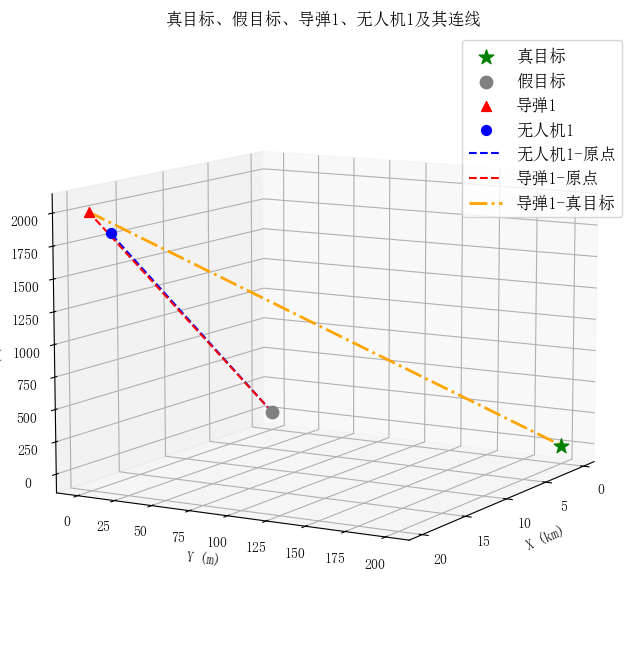

In [ ]:
# 画出真目标、假目标、导弹1、无人机1及其与原点的连线，并补充导弹1与真目标的连线
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 真目标底面圆心 (0, 200, 0)
target = (0, 200, 0)
ax.scatter([target[0]], [target[1]], [target[2]], c='g', marker='*', s=120, label='真目标')
# 假目标 (0, 0, 0)
ax.scatter([0], [0], [0], c='gray', marker='o', s=80, label='假目标')

# 导弹1 (20000, 0, 2000)
m1 = (20, 0, 2000)
ax.scatter([m1[0]], [m1[1]], [m1[2]], c='r', marker='^', s=50, label='导弹1')

# 无人机1 (17800, 0, 1800)
fy1 = (17.8, 0, 1800)
ax.scatter([fy1[0]], [fy1[1]], [fy1[2]], c='b', marker='o', s=50, label='无人机1')

# 无人机1与原点的连线
ax.plot([0, fy1[0]], [0, fy1[1]], [0, fy1[2]], c='b', linestyle='--', label='无人机1-原点')
# 导弹1与原点的连线
ax.plot([0, m1[0]], [0, m1[1]], [0, m1[2]], c='r', linestyle='--', label='导弹1-原点')

# 导弹1与真目标的连线
ax.plot([m1[0], target[0]], [m1[1], target[1]], [m1[2], target[2]], c='orange', linestyle='-.', linewidth=2, label='导弹1-真目标')

# 坐标轴设置
ax.set_xlabel('X (km)')
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('真目标、假目标、导弹1、无人机1及其连线')
ax.legend(fontsize=12)
ax.view_init(elev=10, azim=30)  
plt.show()

# Problem 2

In [24]:
import math
import numpy as np

def calc_cover_intervals(f_speed, f_dir, t_release, t_burst, smoke_v0=-3, smoke_radius=10, g=9.80665):
    """
    计算遮蔽时间区间
    f_speed: 无人机速度(m/s)
    f_dir: 无人机运动方向(3维单位向量, 只能等高, z=0)
    t_release: 投放炸弹的时间(s)
    t_burst: 投放后多久炸弹起爆(s)
    smoke_v0: 烟幕弹竖直初速度(默认-3m/s)
    smoke_radius: 烟幕半径(默认7m)
    g: 重力加速度(默认9.80665)
    返回： 遮蔽区间列表，每个元素为(start, end)，以烟幕起爆时为0
    """
    # 固定参数
    m1 = np.array([20000, 0, 2000], dtype=np.float64)
    true_target = np.array([0, 200, 5], dtype=np.float64)
    v_m = 300  # m/s
    f1 = np.array([17800, 0, 1800], dtype=np.float64)  # 无人机1初始位置
    fake_target = np.array([0, 0, 0], dtype=np.float64)
    
    # 计算方向向量（向量化操作）
    dir_vec = (fake_target - m1) / np.linalg.norm(fake_target - m1)
    f_dir = np.array([np.cos(f_dir), np.sin(f_dir), 0], dtype=np.float64)

    # 计算各关键时刻位置（向量化操作）
    missile_release = m1 + v_m * (t_release + t_burst) * dir_vec
    f_release = f1 + f_speed * (t_release + t_burst) * f_dir
    
    # 烟幕弹起爆点（投放后t_burst秒，抛体运动）
    smoke_burst = np.array([
        f_release[0], 
        f_release[1], 
        f_release[2] + (-0.5) * g * t_burst**2
    ], dtype=np.float64)

    # 生成时间数组（向量化操作的基础）
    t_list = np.linspace(0, 20, 40001, dtype=np.float64)
    missile_positions = missile_release[:, np.newaxis] + v_m * (t_burst + t_list) * dir_vec[:, np.newaxis]
    
    # 向量化计算烟幕位置
    smoke_z = smoke_burst[2] + smoke_v0 * t_list
    smoke_positions = np.stack([
        np.full_like(t_list, smoke_burst[0]),
        np.full_like(t_list, smoke_burst[1]),
        smoke_z
    ], axis=0)

    # 向量化计算是否有交集
    d = true_target[:, np.newaxis] - missile_positions  # 目标到导弹的向量
    d_norm2 = np.sum(d **2, axis=0)  # 向量d的模方
    
    f = missile_positions - smoke_positions  # 导弹到烟幕中心的向量
    a = d_norm2
    b = 2 * np.sum(d * f, axis=0)  # 2*(d·f)
    c = np.sum(f** 2, axis=0) - smoke_radius **2  # |f|² - r²
    
    delta = b** 2 - 4 * a * c  # 判别式
    sqrt_delta = np.sqrt(np.maximum(delta, 0))  # 避免负数开方
    
    with np.errstate(divide='ignore', invalid='ignore'):
        s1 = (-b - sqrt_delta) / (2 * a)
        s2 = (-b + sqrt_delta) / (2 * a)
    in_smoke = ((0 <= s1) & (s1 <= 1)) | ((0 <= s2) & (s2 <= 1))
    in_smoke[delta < 0] = False
    intervals = []
    if np.any(in_smoke):
        # 找到状态变化的位置
        transitions = np.where(np.diff(in_smoke.astype(int)) != 0)[0]
        start = None
        
        # 处理起始状态
        if in_smoke[0]:
            start = t_list[0]
        
        # 处理中间的状态变化
        for i in transitions:
            if start is None:
                start = t_list[i + 1]
            else:
                intervals.append((start, t_list[i + 1]))
                start = None
        
        # 处理结束状态
        if start is not None:
            intervals.append((start, t_list[-1]))
    
    total_time = sum(end - start for start, end in intervals)
    return total_time

# 示例：无人机速度120m/s,4.1s投放，1.5s后起爆
intervals = calc_cover_intervals(
    f_speed=120,
    f_dir=math.pi/4,
    t_release=4.1,
    t_burst=1.5,
)
print("遮蔽区间（以烟幕起爆为0）：", intervals)


遮蔽区间（以烟幕起爆为0）： 0


In [25]:
import random
import math
import numpy as np
from tqdm.notebook import tqdm
E_list = []

def simulated_annealing(initial_temp=10000, cooling_rate=0.94, num_iterations=50000, max_params_to_change=3,reset_from_best=2000):
    """
    使用模拟退火算法寻找最小面积，支持多参数同时调整
    参数:
        initial_temp: 初始温度
        
    参数:
        initial_temp: 初始温度
        cooling_rate: 冷却速率 (0 < cooling_rate < 1)
        num_iterations: 迭代次数
        max_params_to_change: 每次最多调整的参数数量
        
    返回:
        最优参数和对应的最小面积
    """
    # 参数范围
    param_ranges = {
        'speed': (70, 140),
        'dir': (0, 2 * math.pi),
        't_release': (0, 50),
        't_burst': (0, 10),
    }
    # 生成初始解
    current_params = {
        'speed': random.uniform(*param_ranges['speed']),
        'dir': random.uniform(*param_ranges['dir']),
        't_release': random.uniform(*param_ranges['t_release']),
        't_burst': random.uniform(*param_ranges['t_burst']),
    }
    # 计算初始解的面积（假设minimize_area已定义）
    current_E = calc_cover_intervals(current_params['speed'], current_params['dir'], current_params['t_release'], current_params['t_burst'])
    print("正在寻找初始解")
    
    # 如果初始解不满足条件，寻找一个满足条件的初始解
    while current_E == 0:
        current_params = {
            'speed': random.uniform(*param_ranges['speed']),
            'dir': random.uniform(*param_ranges['dir']),
            't_release': random.uniform(*param_ranges['t_release']),
            't_burst': random.uniform(*param_ranges['t_burst']),
        }
        current_E = calc_cover_intervals(current_params['speed'], current_params['dir'], current_params['t_release'], current_params['t_burst'])

    # 保存最优解
    best_params = current_params.copy()
    best_E = current_E
    
    temp = initial_temp
    params_list = []
    # 退火过程
    print("找到初始解，下面开始退火算法")
    for i in tqdm(range(num_iterations), desc="Simulated Annealing Progress", unit="iteration"):
        if i % 1000 == 0:
            print(f"迭代{i}, 当前温度: {temp:.2f}, 当前E: {current_E}, 最优E: {best_E}")
        # 生成邻近解：多参数同时调整
        new_params = current_params.copy()
        # 随机选择要调整的参数数量（1到max_params_to_change之间）
        num_params = random.randint(1, max_params_to_change)
        # 随机选择要调整的参数
        params_to_change = random.sample(list(param_ranges.keys()), num_params)
        
        for param in params_to_change:
            range_min, range_max = param_ranges[param]
            param_range = range_max - range_min  # 参数取值范围大小
            max_perturb = 0.1 * param_range  # 最大调整幅度为范围的10%
            
            # 扰动幅度与温度相关，但不超过最大调整幅度
            base_perturb = (random.random() - 0.5) * 2 * temp * 0.01 * param_range
            perturbation = max(-max_perturb, min(base_perturb, max_perturb))  # 限制在±10%范围内
            
            # 计算新值并确保在范围内
            new_value = new_params[param] + perturbation
            new_value = max(range_min, min(new_value, range_max))
            new_params[param] = new_value
        if i % reset_from_best == 0:
            new_params = best_params.copy()
        # 计算新解的面积
        new_E = calc_cover_intervals(
            new_params['speed'],
            new_params['dir'],
            new_params['t_release'],
            new_params['t_burst']
        )
        
        # 如果新解不满足条件，以小概率接受
        if not new_E:
            E_list.append(0)
            continue
        E_list.append(new_E)
        # 计算能量差（面积差）
        E_diff = new_E - current_E  # 因为我们要最小化面积
        
        # 接受准则：新面积更小则一定接受；否则按概率接受
        if E_diff > 0 or random.random() < math.exp(E_diff / temp):
            current_params = new_params
            current_E = new_E
            
            # 更新最优解
            if current_E > best_E:
                best_params = current_params.copy()
                best_E = current_E
                params_list.append(best_params)
        
        # 降低温度
        if i % 100 == 0:
            temp *= cooling_rate
    return best_params, best_E

params_2, E_2 = simulated_annealing()
print(f"最优参数：{params_2}, 最大E：{E_2}")

正在寻找初始解
找到初始解，下面开始退火算法


Simulated Annealing Progress:   0%|          | 0/50000 [00:00<?, ?iteration/s]

迭代0, 当前温度: 10000.00, 当前E: 0.8935000000000001, 最优E: 0.8935000000000001
迭代1000, 当前温度: 7339.04, 当前E: 2.364, 最优E: 3.1670000000000003


KeyboardInterrupt: 

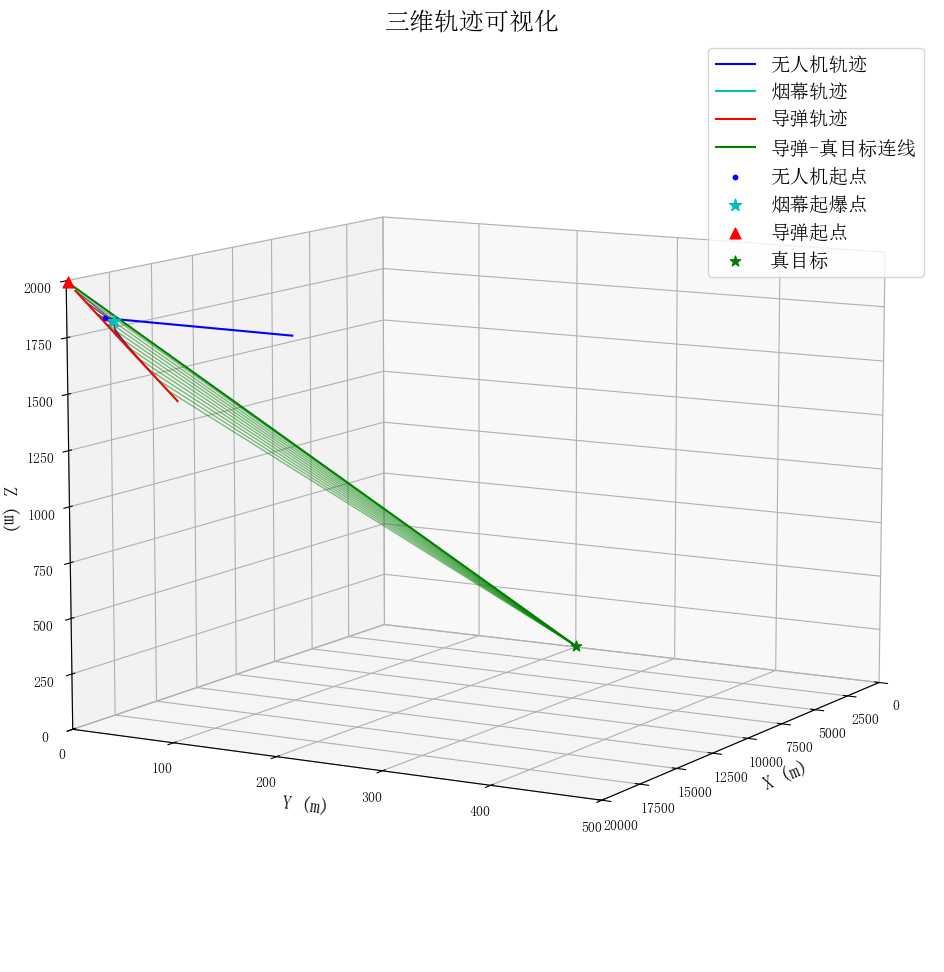

In [ ]:
def visualize_burst(f_speed, f_dir, t_release, t_burst, smoke_v0=-3, smoke_radius=7, g=9.80665):
    """
    可视化无人机、烟幕、导弹、导弹-真目标连线的三维轨迹
    参数同calc_cover_intervals
    """
    # 固定参数
    m1 = np.array([20000, 0, 2000], dtype=np.float64)
    true_target = np.array([0, 200, 5], dtype=np.float64)
    v_m = 300  # m/s
    f1 = np.array([17800, 0, 1800], dtype=np.float64)
    fake_target = np.array([0, 0, 0], dtype=np.float64)

    # 方向向量
    dir_vec = (fake_target - m1) / np.linalg.norm(fake_target - m1)
    f_dir_vec = np.array([np.cos(f_dir), np.sin(f_dir), 0], dtype=np.float64)

    # 关键点
    missile_release = m1 + v_m * t_release * dir_vec
    f_release = f1 + f_speed * t_release * f_dir_vec
    smoke_burst = np.array([
        f_release[0], 
        f_release[1], 
        f_release[2] + (-0.5) * g * t_burst**2
    ], dtype=np.float64)

    # 时间序列
    t_list = np.linspace(0, 20, 2000)

    # 轨迹
    # 无人机轨迹
    f1_traj = f1[:, None] + f_speed * (t_list[None, :]) * f_dir_vec[:, None]
    # 烟幕轨迹（从起爆点开始）
    smoke_traj = np.vstack([
        np.full_like(t_list, smoke_burst[0]),
        np.full_like(t_list, smoke_burst[1]),
        smoke_burst[2] + smoke_v0 * t_list
    ])
    # 导弹轨迹（从投放点起）
    missile_traj = missile_release[:, None] + v_m * (t_burst + t_list)[None, :] * dir_vec[:, None]
    # 导弹-真目标连线
    missile2target = np.vstack([
        np.linspace(missile_release[0], true_target[0], 100),
        np.linspace(missile_release[1], true_target[1], 100),
        np.linspace(missile_release[2], true_target[2], 100)
    ])

    # 绘图
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(f1_traj[0,:500], f1_traj[1,:500], f1_traj[2,:500], 'b-', label='无人机轨迹')
    ax.plot(smoke_traj[0,:500], smoke_traj[1,:500], smoke_traj[2,:500], 'c-', label='烟幕轨迹')
    for i in range(0, missile_traj.shape[1], 200):  # 200可根据轨迹点数调整
        ax.plot(
            [missile_traj[0, i], smoke_traj[0, i]],
            [missile_traj[1, i], smoke_traj[1, i]],
            [missile_traj[2, i], smoke_traj[2, i]],
            color='purple', linestyle='-', linewidth=1, alpha=0.7
        )
    ax.plot(missile_traj[0], missile_traj[1], missile_traj[2], 'r-', label='导弹轨迹')
    ax.plot(missile2target[0], missile2target[1], missile2target[2], 'g-', label='导弹-真目标连线')
    for i in range(0, missile_traj.shape[1], 200):  # 200可根据轨迹点数调整
       ax.plot(
           [missile_traj[0, i], true_target[0]],
           [missile_traj[1, i], true_target[1]],
           [missile_traj[2, i], true_target[2]],
           'g-', linewidth=1, alpha=0.5
       )

    # 标记关键点
    ax.scatter(*f1, c='b', s=10, marker='o', label='无人机起点')
    ax.scatter(*smoke_burst, c='c', s=80, marker='*', label='烟幕起爆点')
    ax.scatter(*missile_release, c='r', s=60, marker='^', label='导弹起点')
    ax.scatter(*true_target, c='g', s=60, marker='*', label='真目标')
    x_max = 20000
    y_max = 500
    z_max = 2000
    
    ax.set_xlabel('X (m)', fontsize=14)
    ax.set_ylabel('Y (m)', fontsize=14)
    ax.set_zlabel('Z (m)', fontsize=14)
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)
    ax.set_zlim(0, z_max)
    ax.set_title('三维轨迹可视化', fontsize=18)
    ax.legend(fontsize=14)
    ax.view_init(elev=10, azim=30)  
    plt.show()


visualize_burst(
    f_speed=params_2['speed'],
    f_dir=params_2['dir'],
    t_release=params_2['t_release'],
    t_burst=params_2['t_burst']
)

In [ ]:
params_2

{'speed': 74.5412803117943,
 'dir': 0.5296763534336987,
 't_release': 0.2617581251634976,
 't_burst': 1.4893282896241713}

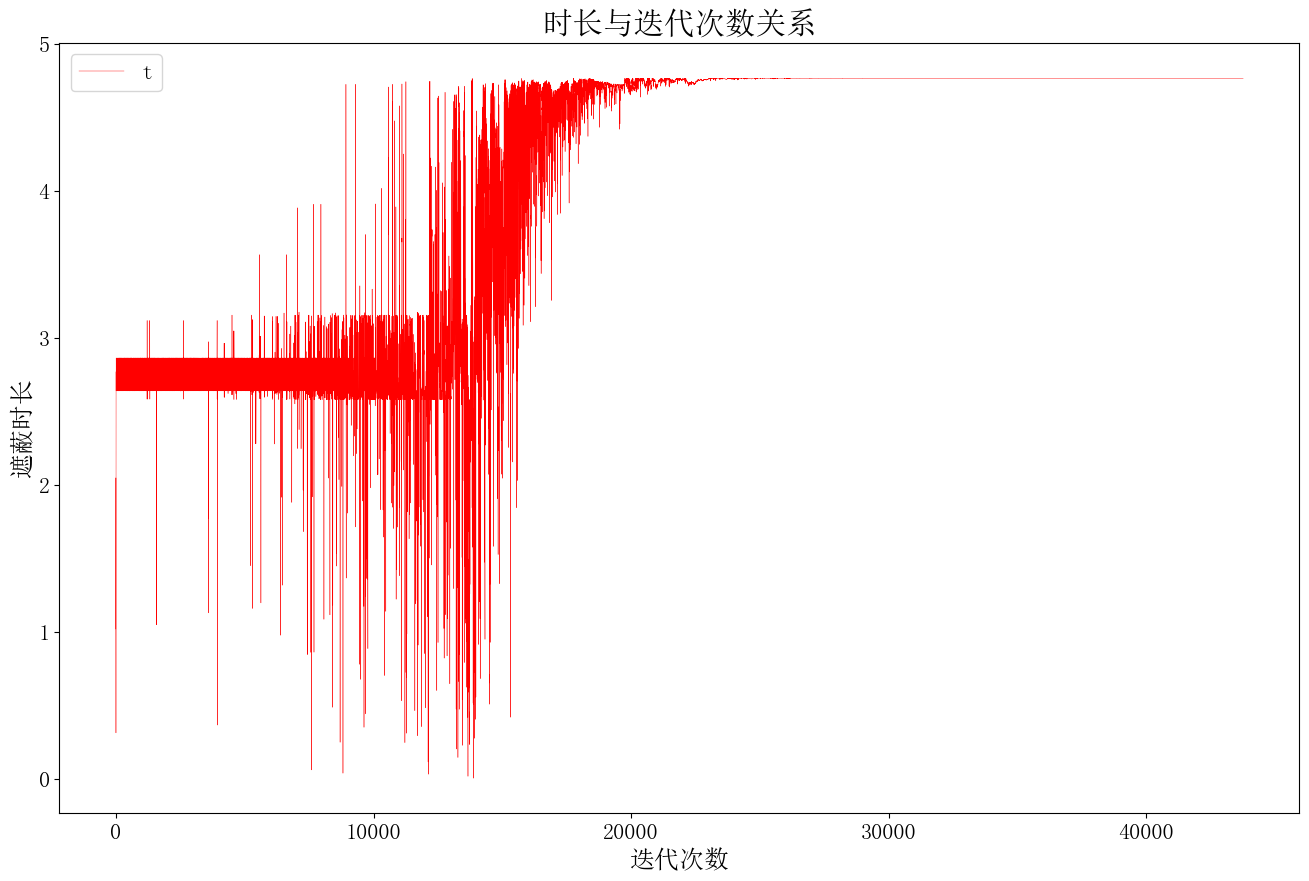

: 

In [ ]:
plt.figure(figsize=(16, 10))
E_no_zero = [E for E in E_list if E>0]
plt.plot(E_no_zero, linewidth=0.3, c="r", label="t")
plt.xlabel("迭代次数", fontsize=18)
plt.ylabel("遮蔽时长", fontsize=18)
plt.title("时长与迭代次数关系", fontsize=22)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Problem 3

In [ ]:
def calc_cover_intervals2(f_speed, f_dir, t1_release, t1_burst, t2_release, t2_burst, smoke_v0=-3, g=9.80665):
    """
    计算遮蔽总时长（两个球体，任一球距离<10即算遮蔽）
    f_speed: 无人机速度(m/s)
    f_dir: 无人机运动方向(3维单位向量, 只能等高, z=0)
    t1_release, t2_release: 两次投放时间(s)
    t1_burst, t2_burst: 两次投放后起爆延时(s)
    smoke_v0: 烟幕弹竖直初速度(默认-3m/s)
    g: 重力加速度(默认9.80665)
    返回：遮蔽总时长（float, 单位秒）
    """
    m1 = np.array([20000, 0, 2000], dtype=np.float64)
    true_target = np.array([0, 200, 5], dtype=np.float64)
    v_m = 300  # m/s
    f1 = np.array([17800, 0, 1800], dtype=np.float64)
    fake_target = np.array([0, 0, 0], dtype=np.float64)
    dir_vec = (fake_target - m1) / np.linalg.norm(fake_target - m1)
    f_dir_vec = np.array([np.cos(f_dir), np.sin(f_dir), 0], dtype=np.float64)

    # 计算两次烟幕球起爆点
    def get_smoke_burst(t_release, t_burst):
        f_release = f1 + f_speed * t_release * f_dir_vec
        return np.array([f_release[0], f_release[1], f_release[2] + (-0.5) * g * t_burst**2], dtype=np.float64)

    smoke_burst1 = get_smoke_burst(t1_release, t1_burst)
    smoke_burst2 = get_smoke_burst(t2_release, t2_burst)

    # 生成时间数组
    t_list = np.linspace(0, 20, 40001, dtype=np.float64)

    # 导弹轨迹
    missile_release = m1 + v_m * t1_release * dir_vec  # 以第一次投放为基准
    missile_positions = missile_release[:, np.newaxis] + v_m * (t1_burst + t_list) * dir_vec[:, np.newaxis]

    # 两个烟幕球轨迹
    smoke_z1 = smoke_burst1[2] + smoke_v0 * t_list
    smoke_pos1 = np.stack([np.full_like(t_list, smoke_burst1[0]), np.full_like(t_list, smoke_burst1[1]), smoke_z1], axis=0)
    smoke_z2 = smoke_burst2[2] + smoke_v0 * t_list
    smoke_pos2 = np.stack([np.full_like(t_list, smoke_burst2[0]), np.full_like(t_list, smoke_burst2[1]), smoke_z2], axis=0)

    missile_pos = missile_positions.T  # (N,3)
    smoke1 = smoke_pos1.T
    smoke2 = smoke_pos2.T
    target = true_target

    # 计算到两个球的距离
    ab = target - missile_pos         # (N,3)
    ap1 = smoke1 - missile_pos
    ap2 = smoke2 - missile_pos
    ab_norm2 = np.sum(ab**2, axis=1)

    s1 = np.sum(ap1 * ab, axis=1) / ab_norm2
    closest1 = missile_pos + ab * s1[:, None]
    dist1 = np.linalg.norm(smoke1 - closest1, axis=1)

    s2 = np.sum(ap2 * ab, axis=1) / ab_norm2
    closest2 = missile_pos + ab * s2[:, None]
    dist2 = np.linalg.norm(smoke2 - closest2, axis=1)

    in_smoke = (dist1 <= 10) | (dist2 <= 10)

    # 检测区间
    intervals = []
    if np.any(in_smoke):
        transitions = np.where(np.diff(in_smoke.astype(int)) != 0)[0]
        start = None
        if in_smoke[0]:
            start = t_list[0]
        for i in transitions:
            if start is None:
                start = t_list[i + 1]
            else:
                intervals.append((start, t_list[i + 1]))
                start = None
        if start is not None:
            intervals.append((start, t_list[-1]))
    total_time = sum(end - start for start, end in intervals)
    return total_time

# 示例：无人机速度120m/s，两次投放
total_time = calc_cover_intervals2(
    f_speed=120,
    f_dir=math.pi/4,
    t1_release=4.1, t1_burst=1.5,
    t2_release=7.0, t2_burst=1.5,
    smoke_v0=-3, g=9.8
    )
print("两球遮蔽总时长（秒）：", total_time)

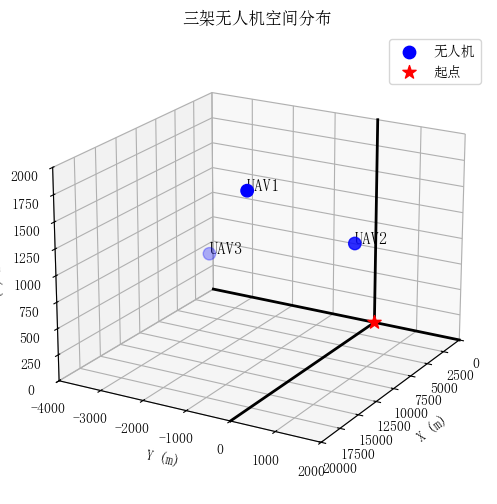

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
plt.rcParams["font.family"] = ["SimSun"]
plt.rcParams['axes.unicode_minus'] = False
drones = [
    ([17800, 0, 2000], 137, 3.1, 0, 3),
    ([12000, 1400, 1400], 120, 2.5, 2, 3),
    ([6000, -3000, 700], 100, 1.8, 4, 3)
]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 提取无人机位置
positions = np.array([d[0] for d in drones])
x, y, z = positions[:,0], positions[:,1], positions[:,2]

ax.scatter(x, y, z, c='b', marker='o', s=80, label='无人机')
ax.scatter(0, 0, 0, c='r', marker='*', s=100, label='起点')
# 标注编号
for i, (px, py, pz) in enumerate(positions):
    ax.text(px, py, pz, f'UAV{i+1}', fontsize=12, color='black')

# 自动计算y轴范围，居中显示原点
y_min = min(-4000, np.min(y))
y_max = max(2000, np.max(y))
ax.set_xlim(0, 20000)
ax.set_ylim(y_min, y_max)
ax.set_zlim(0, 2000)

# 绘制三条坐标轴线
ax.plot([0, 20000], [0, 0], [0, 0], color='black', linewidth=2)  # X轴
ax.plot([0, 0], [y_min, y_max], [0, 0], color='black', linewidth=2)  # Y轴
ax.plot([0, 0], [0, 0], [0, 2000], color='black', linewidth=2)  # Z轴

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('三架无人机空间分布')
ax.legend()
ax.view_init(elev=20, azim=30)  
plt.show()